### Redes Neurais e Aprendizado Profundo
#### **MBA em Ciências de Dados**

### *Módulo 4 - Treinamento de Redes Profundas*

**Taxa de aprendizado**

Moacir A. Ponti

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

# 1. Preparando Dataset

In [3]:
# Carregando dataset a partir de TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train[:12%]', 'test[:20%]'], 
                                         as_supervised=True, with_info=True)
num_classes = ds_info.features['label'].num_classes

In [4]:
# Get the image resolution
input_shape = ds_info.features['image'].shape

# Get the size of each set
num_train_examples = tf.data.experimental.cardinality(ds_train).numpy()
num_test_examples = tf.data.experimental.cardinality(ds_test).numpy()

# Get the number of classes
num_classes = ds_info.features['label'].num_classes

# Print the obtained information
print(f"Resolução: {input_shape}")
print(f"Training Set: {num_train_examples} exemplos")
print(f"Testing Set: {num_test_examples} exemplos")
print(f"Classes: {num_classes}")

Resolução: (32, 32, 3)
Training Set: 6000 exemplos
Testing Set: 2000 exemplos
Classes: 10


Temos portando 60 mil exemplos de treinamento

Imagens de tamanho $28\times 28$ e 10 classes.

Agora, o passo ideal é pré-processar as imagens para facilitar o processo de otimização das redes neurais:

1. Normalizar seus valores (para o intervalo 0-1)
2. Alterar a codificação das classes (para one-hot-encoding): teremos 10 neurônios na saída, não apenas 1

2023-10-08 17:38:56.727355: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


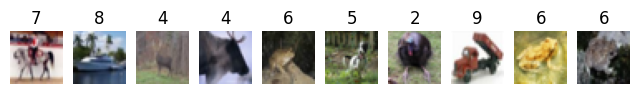

In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(8, 3))
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{label}")
    plt.show()

# extrai primeiras 10 imagens para exibir
list_images = []
list_labels = []
for example in ds_train.take(10):
    image = example[0].numpy()
    label = example[1].numpy()
    list_images.append(image)
    list_labels.append(label)
    
show_images(list_images, list_labels)

In [6]:
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label
    
# Pre-processa imagens
def preprocess_image(image, label):
    # converte imagem para float32
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

ds_train = ds_train.map(preprocess_image)
ds_test = ds_test.map(preprocess_image)

ds_train = ds_train.map(one_hot_label)
ds_test = ds_test.map(one_hot_label)

# 2. Definindo Rede Neural


In [34]:
def XceptionCNN(input_shape, num_classes, n_filters=32, blocks=3):
    
    input_tensor = keras.layers.Input(shape=input_shape)
    x = input_tensor

    #x = keras.layers.Conv2D(n_filters, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    
    # Blocos separaveis em profundidade + MaxPooling
    x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
    
    # Achatar a saída do bloco residual
    x = keras.layers.Flatten()(x)
    
    # Camada densa/fully connected
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.325)(x)
    
    output_tensor = keras.layers.Dense(num_classes, activation='softmax')(x)  
    
    # Cria o modelo com base na entrada e saída
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)

    return model


Definindo sementes e um subconjunto menor para testarmos


In [8]:
epochs = 16
batch_size = 32

ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)

# 3. Explorando Diferentes Estratégias para o Learning Rate

## 3.1 - Learning Rate Fixo

In [42]:
CNN1 = XceptionCNN(input_shape, 10)
CNN1.summary()
CNN1.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 depthwise_conv2d_28 (Depth  (None, 32, 32, 3)         30        
 wiseConv2D)                                                     
                                                                 
 batch_normalization_28 (Ba  (None, 32, 32, 3)         12        
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 32, 32, 3)         0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 16, 16, 3)         0         
 ng2D)                                                           
                                                          

In [43]:
hist1 = CNN1.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, validation_data=(ds_test))

Epoch 1/16
188/188 [==============================] - 7s 29ms/step - loss: 2.6806 - accuracy: 0.1115 - val_loss: 2.3075 - val_accuracy: 0.0965
Epoch 2/16
188/188 [==============================] - 5s 26ms/step - loss: 2.3494 - accuracy: 0.1613 - val_loss: 2.2634 - val_accuracy: 0.1470
Epoch 3/16
188/188 [==============================] - 5s 25ms/step - loss: 2.2162 - accuracy: 0.2002 - val_loss: 2.1395 - val_accuracy: 0.2340
Epoch 4/16
188/188 [==============================] - 5s 25ms/step - loss: 2.1368 - accuracy: 0.2278 - val_loss: 2.0783 - val_accuracy: 0.2600
Epoch 5/16
188/188 [==============================] - 5s 28ms/step - loss: 2.0757 - accuracy: 0.2627 - val_loss: 2.0253 - val_accuracy: 0.2830
Epoch 6/16
188/188 [==============================] - 5s 26ms/step - loss: 2.0192 - accuracy: 0.2715 - val_loss: 1.9841 - val_accuracy: 0.2975
Epoch 7/16
188/188 [==============================] - 5s 27ms/step - loss: 1.9769 - accuracy: 0.2968 - val_loss: 1.9553 - val_accuracy: 0.3155

## 3.2 - Learning Rate Alto 
- **(muito alto)**

In [44]:
print("Modelo 2 - Learning Rate Alto (Adam)")
CNN2 = XceptionCNN(input_shape, 10)
CNN2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.09),
              metrics=['accuracy'])

hist2 = CNN2.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, validation_data=(ds_test))

Modelo 2 - Learning Rate Alto (Adam)
Epoch 1/16
188/188 [==============================] - 7s 27ms/step - loss: 2.5831 - accuracy: 0.1048 - val_loss: 2.3101 - val_accuracy: 0.1025
Epoch 2/16
188/188 [==============================] - 5s 25ms/step - loss: 2.3137 - accuracy: 0.1013 - val_loss: 2.3105 - val_accuracy: 0.1025
Epoch 3/16
188/188 [==============================] - 5s 25ms/step - loss: 2.3139 - accuracy: 0.1020 - val_loss: 2.3108 - val_accuracy: 0.1025
Epoch 4/16
188/188 [==============================] - 5s 26ms/step - loss: 2.3140 - accuracy: 0.1020 - val_loss: 2.3111 - val_accuracy: 0.1025
Epoch 5/16
188/188 [==============================] - 5s 26ms/step - loss: 2.3141 - accuracy: 0.1020 - val_loss: 2.3112 - val_accuracy: 0.1025
Epoch 6/16
188/188 [==============================] - 5s 27ms/step - loss: 2.3141 - accuracy: 0.1020 - val_loss: 2.3113 - val_accuracy: 0.1025
Epoch 7/16
188/188 [==============================] - 5s 25ms/step - loss: 2.3141 - accuracy: 0.1020 - va

## 3.2 - SGD + Momentum com peso 0.9


In [45]:
print("Modelo 3- Momentum")
CNN3 = XceptionCNN(input_shape, 10)
CNN3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.005, momentum=0.95),
              metrics=['accuracy'])

hist3 = CNN3.fit(ds_train,
                 batch_size=batch_size,
                 epochs=epochs, validation_data=(ds_test))

Modelo 3- Momentum
Epoch 1/16
188/188 [==============================] - 6s 27ms/step - loss: 2.1598 - accuracy: 0.2215 - val_loss: 2.0331 - val_accuracy: 0.2850
Epoch 2/16
188/188 [==============================] - 5s 27ms/step - loss: 1.9048 - accuracy: 0.3102 - val_loss: 1.8176 - val_accuracy: 0.3470
Epoch 3/16
188/188 [==============================] - 5s 26ms/step - loss: 1.8008 - accuracy: 0.3553 - val_loss: 1.7466 - val_accuracy: 0.3620
Epoch 4/16
188/188 [==============================] - 5s 26ms/step - loss: 1.7346 - accuracy: 0.3733 - val_loss: 1.6851 - val_accuracy: 0.3915
Epoch 5/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6840 - accuracy: 0.3892 - val_loss: 1.7836 - val_accuracy: 0.3545
Epoch 6/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6455 - accuracy: 0.4058 - val_loss: 1.7370 - val_accuracy: 0.3645
Epoch 7/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6037 - accuracy: 0.4262 - val_loss: 1.6472 - v

## 3.3 - Decaimento de Learning Rate
- com learning Rate inicial um pouco mais alto

In [46]:
print("Modelo 4 - Decaimento de Learning Rate ")
CNN4 = XceptionCNN(input_shape, 10)
CNN4.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.002),
              metrics=['accuracy'])


print("Taxa inicial = ", round(CNN4.optimizer.lr.numpy(), 4))

Modelo 4 - Decaimento de Learning Rate 
Taxa inicial =  0.002


Criando uma função "callback" para definir uma modificação no learning rate ao longo das épocas

In [47]:
def scheduler(epoch, lr):
  #print("Learning rate atual = ", lr)
  if epoch < 2:
    return lr
  else:
    return np.round(lr * tf.math.exp(-0.1), 6)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

hist4 = CNN4.fit(ds_train,
                 batch_size=batch_size, epochs=epochs, 
                 callbacks=[callbacklr],
                 validation_data=(ds_test))


Epoch 1/16
188/188 [==============================] - 7s 27ms/step - loss: 2.0835 - accuracy: 0.2352 - val_loss: 2.1174 - val_accuracy: 0.2090 - lr: 0.0020
Epoch 2/16
188/188 [==============================] - 5s 26ms/step - loss: 1.8632 - accuracy: 0.3082 - val_loss: 1.9776 - val_accuracy: 0.2685 - lr: 0.0020
Epoch 3/16
188/188 [==============================] - 5s 28ms/step - loss: 1.7697 - accuracy: 0.3605 - val_loss: 1.7392 - val_accuracy: 0.3625 - lr: 0.0018
Epoch 4/16
188/188 [==============================] - 5s 26ms/step - loss: 1.7072 - accuracy: 0.3782 - val_loss: 1.6782 - val_accuracy: 0.3905 - lr: 0.0016
Epoch 5/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6697 - accuracy: 0.3892 - val_loss: 1.6710 - val_accuracy: 0.3825 - lr: 0.0015
Epoch 6/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6176 - accuracy: 0.4177 - val_loss: 1.6588 - val_accuracy: 0.3915 - lr: 0.0013
Epoch 7/16
188/188 [==============================] - 5s 27ms/st

In [48]:
print("Modelo 5 - Decaimento de Learning Rate + AdamW")
CNN5 = XceptionCNN(input_shape, 10)
CNN5.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.AdamW(learning_rate=0.002),
              metrics=['accuracy'])

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

hist5 = CNN5.fit(ds_train,
                 batch_size=batch_size, epochs=epochs, 
                 callbacks=[callbacklr],
                 validation_data=(ds_test))

Modelo 5 - Decaimento de Learning Rate + AdamW
Epoch 1/16
188/188 [==============================] - 7s 29ms/step - loss: 2.1631 - accuracy: 0.2218 - val_loss: 2.2652 - val_accuracy: 0.1515 - lr: 0.0020
Epoch 2/16
188/188 [==============================] - 5s 28ms/step - loss: 1.9461 - accuracy: 0.3022 - val_loss: 1.9179 - val_accuracy: 0.3365 - lr: 0.0020
Epoch 3/16
188/188 [==============================] - 6s 30ms/step - loss: 1.8087 - accuracy: 0.3563 - val_loss: 1.7408 - val_accuracy: 0.3885 - lr: 0.0018
Epoch 4/16
188/188 [==============================] - 6s 30ms/step - loss: 1.7280 - accuracy: 0.3790 - val_loss: 1.6957 - val_accuracy: 0.4025 - lr: 0.0016
Epoch 5/16
188/188 [==============================] - 5s 28ms/step - loss: 1.6563 - accuracy: 0.4158 - val_loss: 1.6630 - val_accuracy: 0.4055 - lr: 0.0015
Epoch 6/16
188/188 [==============================] - 5s 26ms/step - loss: 1.6063 - accuracy: 0.4282 - val_loss: 1.6443 - val_accuracy: 0.4210 - lr: 0.0013
Epoch 7/16
188/18

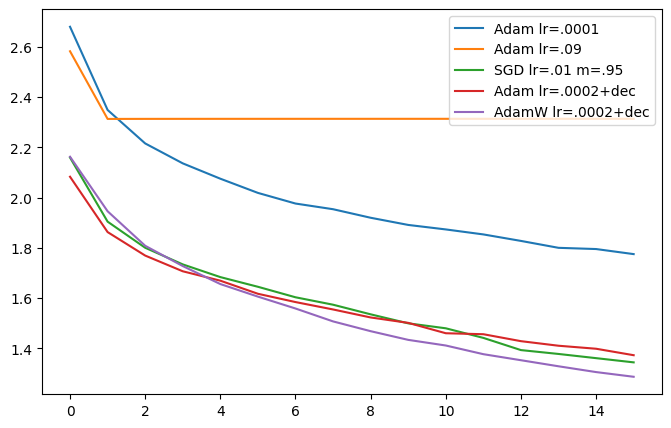

In [49]:
plt.figure(figsize=(8,5))
plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist3.history['loss'])
plt.plot(hist4.history['loss'])
plt.plot(hist5.history['loss'])
plt.legend(["Adam lr=.0001", "Adam lr=.09", "SGD lr=.01 m=.95","Adam lr=.0002+dec","AdamW lr=.0002+dec"], loc="upper right")

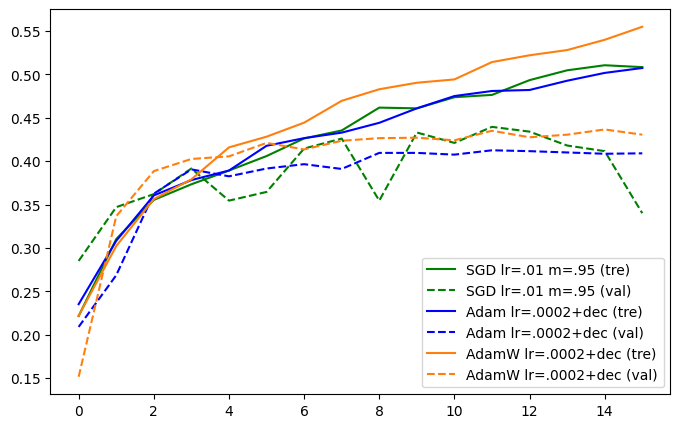

In [57]:
plt.figure(figsize=(8,5))
plt.plot(hist3.history['accuracy'], 'g')
plt.plot(hist3.history['val_accuracy'], 'g--')
plt.plot(hist4.history['accuracy'], 'b')
plt.plot(hist4.history['val_accuracy'], 'b--')
plt.plot(hist5.history['accuracy'], color='tab:orange')
plt.plot(hist5.history['val_accuracy'], color='tab:orange', linestyle='--')
plt.legend(["SGD lr=.01 m=.95 (tre)","SGD lr=.01 m=.95 (val)","Adam lr=.0002+dec (tre)","Adam lr=.0002+dec (val)","AdamW lr=.0002+dec (tre)","AdamW lr=.0002+dec (val)"], loc="lower right")